## Python Programming for Finance

Markos Flavio B. G. O.

__Context: Stock market.__

This notebook covers all main topics and ideas covered in the series Python Programming for Finance, released by sentdex in its Youtube channel (https://www.youtube.com/channel/UCfzlCWGWYyIQ0aLC5w48gBQ).

In [44]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader as web
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import bs4 as bs
import pickle
import requests
import datetime as dt
import os
from collections import Counter
from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

style.use('ggplot')
%matplotlib inline

#### Getting data from web

The 'Date' column appears slighlty below because it's the index of this table.

In [4]:
start = dt.datetime(2017,1,1)
end = dt.datetime.now()
df = web.DataReader('TSLA', 'yahoo', start, end) # stock symbol (ticker); source of data; start time; end time
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-05,323.510010,316.119995,319.619995,317.220001,6943400,317.220001
2019-11-06,326.720001,314.500000,318.000000,326.579987,7940900,326.579987
2019-11-07,341.500000,328.019989,329.140015,335.540009,14467300,335.540009
2019-11-08,337.459991,332.500000,334.500000,337.140015,6069200,337.140015
2019-11-11,349.190002,342.000000,343.950012,345.089996,9986700,345.089996


Adjusted close price of a stock is considered to be the true price of that stock. The closing price is the 'raw' price which is just the cash value of the last transacted price before the market closes. The adjusted closing price amends a stock's closing price to accurately reflect that stock's value after accounting for any corporate actions, such as stock splits, dividends/distributions and rights offerings.
    - Adjusting Prices for Stock Splits: a company undergoing a stock split (to make their share prices more marketable) must adjust its closing price to depict the effect of the corporate action. For example, a company's board of directors may decide to split the company's stock three-for-one. If a stock closed at $300 the day before its stock split, the closing price is adjusted to $100 ($300 divided by 3) per share to show the effect of this corporate action: the new price of $100 would appear in the Adj. Close column.
    - Adjusting for Dividends: common distributions that affect a stock's price include cash dividends and stock dividends. The difference between cash dividends and stock dividends is that shareholders are entitled to a predetermined price per share and additional shares, respectively. For example, assume a company declared a $1 cash dividend and is trading at $51 per share on the ex-dividend date. On the ex-dividend date, the stock price is reduced by $1 and the adjusted closing price is $50. While dividends are welcomed by shareholders, they actually lower the value of each share of company stock. The reason is that profits are being disbursed to shareholders instead of being reinvested back into growing the company which is seen as devaluing the company. This devaluation will be captured by the adjusted closing price.
    - Adjusting for Rights Offerings: a rights offering is an issue of rights given to existing shareholders, which entitles the shareholders to subscribe to the rights issue in proportion to their shares. This will lower the value of existing shares because supply increases have a dilutive effect on the existing shares. Assume a company declares a rights offering, in which existing shareholders are entitled to one additional share for every two shares owned. Assume the stock is trading at $50 and existing shareholders can purchase additional shares at a subscription price of $45. On the ex-date, the adjusted closing price is calculated based on the adjusting factor and the closing price.

#### Exporting and importing data

In [5]:
df.to_csv('tesla.csv') # pulling this data in the same folder as the .ipynb

In [6]:
df = pd.read_csv('tesla.csv', parse_dates = True, index_col='Date')
# if parse_dates is not specified, the 'Date' column will be a column of strings.
# we can also read from .json, .sql, .xls with Pandas.
df_original = df.copy()
df_original.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,220.330002,210.960007,214.860001,216.990005,5923300,216.990005
2017-01-04,228.000000,214.309998,214.750000,226.990005,11213500,226.990005
2017-01-05,227.479996,221.949997,226.419998,226.750000,5911700,226.750000
2017-01-06,230.309998,225.449997,226.929993,229.009995,5527900,229.009995
2017-01-09,231.919998,228.000000,228.970001,231.279999,3979500,231.279999


#### Visualizing data

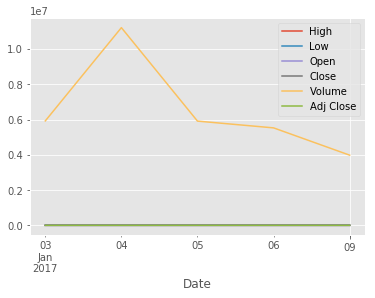

In [7]:
# the Dataframe objects have plot attributes; the x variable is the index of the data frame.
df.head().plot()
#plt.show() # needed if not in an interactive environment.

Because Volume is in a greater scale, we only see its own graph, all other information appear near zero.

Volume is how many shares the shareholders are trading in a given period of time. For every buyer, there is a seller, and each transaction contributes to the count of total volume. That is, when buyers and sellers agree to make a transaction at a certain price, it is considered one transaction. If only five transactions occur in a day, the volume for the day is five.

In [8]:
df[['Open', 'High']].head()

,Open,High
Date,,
2017-01-03,214.860001,220.330002
2017-01-04,214.750000,228.000000
2017-01-05,226.419998,227.479996
2017-01-06,226.929993,230.309998
2017-01-09,228.970001,231.919998


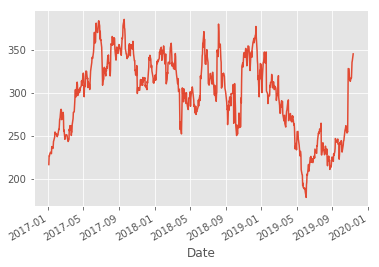

In [9]:
df['Adj Close'].plot()

#### Creating a new column

In [10]:
# use Pandas functions whenever available due efficiency. If not available,
# write your own functions and map those to column(s).

In [11]:
# creating a new column for 100 moving average
df['100ma'] = df['Adj Close'].rolling(window=100).mean()
# the moving average includes the current price and previous prices (in the example, 99 prices)
# moving averages smooth out prices over time and people use it for detecting trends:
# for example, people may say that if the 50 moving average crosses (above) the 2*50 moving average,
# it's a signal of an up trending.

In [12]:
print(df.head()) # the first 99 columns have NaN for the 100ma
print(df.tail())

                  High         Low        Open       Close    Volume  \
Date                                                                   
2017-01-03  220.330002  210.960007  214.860001  216.990005   5923300   
2017-01-04  228.000000  214.309998  214.750000  226.990005  11213500   
2017-01-05  227.479996  221.949997  226.419998  226.750000   5911700   
2017-01-06  230.309998  225.449997  226.929993  229.009995   5527900   
2017-01-09  231.919998  228.000000  228.970001  231.279999   3979500   

             Adj Close  100ma  
Date                           
2017-01-03  216.990005    NaN  
2017-01-04  226.990005    NaN  
2017-01-05  226.750000    NaN  
2017-01-06  229.009995    NaN  
2017-01-09  231.279999    NaN  
                  High         Low        Open       Close    Volume  \
Date                                                                   
2019-11-05  323.510010  316.119995  319.619995  317.220001   6943400   
2019-11-06  326.720001  314.500000  318.000000  326.579

In [13]:
df.dropna(inplace=True) # dropping any record with NaN values

In [14]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,100ma
Date,,,,,,,
2017-05-25,316.970001,307.809998,311.019989,316.829987,5014000,316.829987,274.872101
2017-05-26,325.489990,316.309998,317.279999,325.140015,7802200,325.140015,275.953601
2017-05-30,336.279999,325.760010,326.000000,335.100006,7782900,335.100006,277.034701
2017-05-31,342.890015,335.160004,337.690002,341.010010,9963400,341.010010,278.177301
2017-06-01,344.880005,337.290009,344.000000,340.369995,7608000,340.369995,279.290901


In [15]:
# we can set min_periods parameter to zero to avoid losing any record.
# the first rows will be the average of the previous columns.
# the first value will be the 'Adj Close' value itself.
# the second value will be the average of the first two 'Adj Close'.
# and so on, until the 99th record whose value will be the average of the previous 99 'Adj Close' values including itself.
df = df_original.copy()
df['100ma'] = df['Adj Close'].rolling(window=100, min_periods=0).mean()
df['50ma'] = df['Adj Close'].rolling(window=50, min_periods=0).mean()

In [16]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,100ma,50ma
Date,,,,,,,,
2017-01-03,220.330002,210.960007,214.860001,216.990005,5923300,216.990005,216.990005,216.990005
2017-01-04,228.000000,214.309998,214.750000,226.990005,11213500,226.990005,221.990005,221.990005
2017-01-05,227.479996,221.949997,226.419998,226.750000,5911700,226.750000,223.576670,223.576670
2017-01-06,230.309998,225.449997,226.929993,229.009995,5527900,229.009995,224.935001,224.935001
2017-01-09,231.919998,228.000000,228.970001,231.279999,3979500,231.279999,226.204001,226.204001


#### Ploting data using matplotlib

We can use '%matplotlib qt' to plots figures in a new pop-up window and '%matplotlib inline' to switch back to the inline mode.

<BarContainer object of 720 artists>

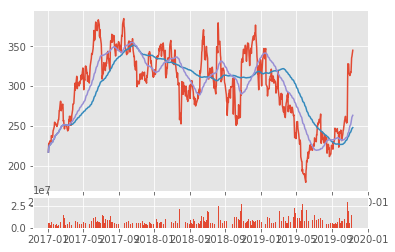

In [17]:
%matplotlib inline
# each subplot of a figure is called an 'axis' in matplotlib, which is unintuitive.
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1) # grid size (6 rows, 1 column),
# starting point ((0,0) is the top-corner) 
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1)
ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax1.plot(df.index, df['50ma'])
ax2.bar(df.index, df['Volume'])
# note that both axes share the same x-scale.

Note that if we zoom-in i the upper graph (if the graph appears in a pop-up window), the below graph will not be aligned. To solve this, we'll add another parameter to ax2 called sharex.

<BarContainer object of 720 artists>

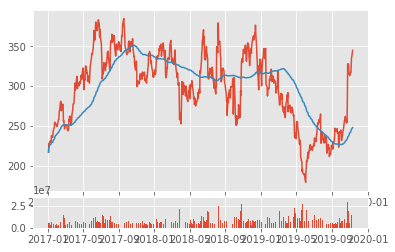

In [18]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1) # grid size (6 rows, 1 column),
# starting point ((0,0) is the top-corner) 
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df['Volume'])

#### Resampling data with Pandas

Resampling is used for grouping data into extensive periods of time. Currently, we have daily data but we may want to resample that to 10 day data. That's very useful when we have data collected in shorted periods of time that is not very useful to have (for example, miliseconds data).

In [19]:
df_ohlc = df['Adj Close'].resample('10D').ohlc() # mean and sum are also valid methods
# note that this is not a moving average, it just takes the mean of
# every 10 days: it reduces the data set by a factor of 10.

'ohlc' means that we'll take the open, high, low and close value for every 10 days.

In [20]:
df_volume = df['Volume'].resample('10D').sum()
# making the sum() of the volume gives us a more meaningul metric, which is itself a volume, rather than a mean.

In [21]:
df_ohlc.head()

,open,high,low,close
Date,,,,
2017-01-03,216.990005,231.279999,216.990005,229.589996
2017-01-13,237.750000,244.729996,235.580002,244.729996
2017-01-23,248.919998,254.610001,248.919998,249.240005
2017-02-02,251.550003,269.230011,251.330002,269.230011
2017-02-12,280.600006,280.980011,268.950012,277.390015


In [22]:
# note that the open value of the df_ohlc data set is equal to the 'Adj close'
# value of the first record in the data set.
df[:1]['Adj Close']

Date
2017-01-03    216.990005
Name: Adj Close, dtype: float64

#### Plotting data using candlesticks
We want to plot this resampling data using candlesticks using the 'candlestick_ohlc' matplotlib's function. However, this function needs five columns: dates (in date format), open, high, low and close. Thus, we need to change the 'Dates' index to a column.

In [23]:
df_ohlc.reset_index(inplace=True)
df_ohlc.head()

,Date,open,high,low,close
0,2017-01-03,216.990005,231.279999,216.990005,229.589996
1,2017-01-13,237.750000,244.729996,235.580002,244.729996
2,2017-01-23,248.919998,254.610001,248.919998,249.240005
3,2017-02-02,251.550003,269.230011,251.330002,269.230011
4,2017-02-12,280.600006,280.980011,268.950012,277.390015


Now, we need to convert the Date column into mdates format, used by matplotlib. This format of date is really strange, but nonetheless, needed to matplotlib.

In [24]:
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)
df_ohlc['Date'].head()

0    736332.0
1    736342.0
2    736352.0
3    736362.0
4    736372.0
Name: Date, dtype: float64

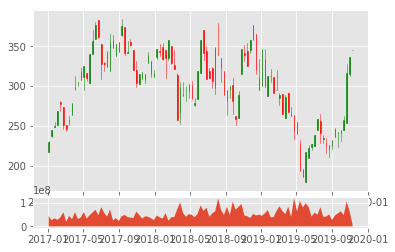

In [25]:
%matplotlib qt
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax1.xaxis_date() # this will convert the silly mdate's number to real date formats.
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g') # remember that
# df_ohlc.values returns the five columns: 'Date' and ohlc columns.
ax2.fill_between(df_volume.index.map(mdates.date2num), # x_data
                 df_volume.values, # y_data,
                 0) # we'll fill from 0 to the y_data

#### Getting the S&P 500 list from the web
S&P 500 gives us the 500 enterprises with highest marketcap of in US. Market cap is basically the value of the company: the number of outstanding shares times the price. **Shares outstanding** refer to a company's stock currently held by all its shareholders, including share blocks held by institutional investors and restricted shares owned by the company's officers and insiders. Outstanding shares are shown on a company's balance sheet under the heading “Capital Stock.”

We'll parse web data using bs4. Particularly, we'll get the tickers of all S&P 500 companies from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies and save that information using pickle, because it's easier (quickier) for future events, to get data sotred locally rather than from a web site.

In [26]:
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml') #lxml parser
    # getting the information by looking at the source html code of the web page.
    table = soup.find('table', {'class': 'wikitable sortable'}) # looking for a table with a particular class name
    tickers = []
    for row in table.findAll('tr')[1:]: #iterating over the table rows (tr) and skipping the header (not necessary for all sites).
        ticker = row.findAll('td')[0].text # 'td' refers to 'table data'
        # '0' specifies the left-most column; which is the ticker data we want.
        #.text is necessary to extract the text information inside a tag from the soup object.
        tickers.append(ticker.replace('\n',''))
        
    with open('sp500_tickers.pkl', 'wb') as f:
        pickle.dump(tickers, f)
    #print(tickers)
    return tickers
save_sp500_tickers()        

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AMG',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ARNC',
 'ANET',
 'AJG',
 'AIZ',
 'ATO',
 'T',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BBT',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'HRB',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CPRI',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CBS',
 'CDW',
 'CE',
 'CELG',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'XEC',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME

#### Getting the Ibovespa data from the web
We'll get the tickers of all Bovespa Index (Ibovespa)  companies from http://www.b3.com.br/en_us/market-data-and-indices/indices/broad-indices/indice-ibovespa-ibovespa-composition-index-portfolio.htm and save that information using pickle.

The content that we want is inside a frame of this page.
<img src="files/images/b3_framed_page.png">

Thus, we need to analyze the page and look for extra network requests that may contain the addresses, and emulate those.
In this case, we need to find a link to a page inside the original one that have the desired information: http://bvmf.bmfbovespa.com.br/indices/ResumoCarteiraTeorica.aspx?Indice=IBOV&idioma=en-us.

In [27]:
def save_ibovespa_tickers():
    resp = requests.get('http://bvmf.bmfbovespa.com.br/indices/ResumoCarteiraTeorica.aspx?Indice=IBOV&idioma=en-us')
    soup = bs.BeautifulSoup(resp.text, 'lxml') #lxml parser
    # getting the information by looking at the source code of the web page.
    tags = soup.findAll("td", {"class": "rgSorted"})
    tickers = []
    for tag in tags:
        tickers.append(tag.text.strip())
    with open('ibovespa_tickers.pkl', 'wb') as f:
        pickle.dump(tickers, f)
    #print(tickers)
    return tickers
save_ibovespa_tickers()

['ABEV3',
 'AZUL4',
 'B3SA3',
 'BBAS3',
 'BBDC3',
 'BBDC4',
 'BBSE3',
 'BPAC11',
 'BRAP4',
 'BRDT3',
 'BRFS3',
 'BRKM5',
 'BRML3',
 'BTOW3',
 'CCRO3',
 'CIEL3',
 'CMIG4',
 'COGN3',
 'CSAN3',
 'CSNA3',
 'CVCB3',
 'CYRE3',
 'ECOR3',
 'EGIE3',
 'ELET3',
 'ELET6',
 'EMBR3',
 'ENBR3',
 'EQTL3',
 'FLRY3',
 'GGBR4',
 'GNDI3',
 'GOAU4',
 'GOLL4',
 'HYPE3',
 'IGTA3',
 'IRBR3',
 'ITSA4',
 'ITUB4',
 'JBSS3',
 'KLBN11',
 'LAME4',
 'LREN3',
 'MGLU3',
 'MRFG3',
 'MRVE3',
 'MULT3',
 'NATU3',
 'PCAR4',
 'PETR3',
 'PETR4',
 'QUAL3',
 'RADL3',
 'RAIL3',
 'RENT3',
 'SANB11',
 'SBSP3',
 'SMLS3',
 'SUZB3',
 'TAEE11',
 'TIMP3',
 'UGPA3',
 'USIM5',
 'VALE3',
 'VIVT4',
 'VVAR3',
 'WEGE3',
 'YDUQ3']

#### Getting data from S&P companies

Here, we're going to get data from yahoo's servers. We'll save that information locally so that we do not need to download all the info every time we need it.

In [28]:
def get_data_from_yahoo(reload_sp500=False, number_enterprises=30): # getting the data for the first 20 companies for simplicity
    # loading sp500 tickers
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('sp500_tickers.pkl', 'rb') as f:
            tickers = pickle.load(f)
    # downloading/loading data
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2018,12,31)
    
    for ticker in tickers[:number_enterprises]:
        print(ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(str(ticker), 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('File already exists: {}'.format(ticker))

get_data_from_yahoo()     

MMM
File already exists: MMM
ABT
File already exists: ABT
ABBV
File already exists: ABBV
ABMD
File already exists: ABMD
ACN
File already exists: ACN
ATVI
File already exists: ATVI
ADBE
File already exists: ADBE
AMD
File already exists: AMD
AAP
File already exists: AAP
AES
File already exists: AES
AMG
File already exists: AMG
AFL
File already exists: AFL
A
File already exists: A
APD
File already exists: APD
AKAM
File already exists: AKAM
ALK
File already exists: ALK
ALB
File already exists: ALB
ARE
File already exists: ARE
ALXN
File already exists: ALXN
ALGN
File already exists: ALGN
ALLE
File already exists: ALLE
AGN
File already exists: AGN
ADS
File already exists: ADS
LNT
File already exists: LNT
ALL
File already exists: ALL
GOOGL
File already exists: GOOGL
GOOG
File already exists: GOOG
MO
File already exists: MO
AMZN
File already exists: AMZN
AMCR
File already exists: AMCR


#### Combining S&P 500 into one DataFrame
Particularly, we want to combine the 'Adj Close' value from all stocks whose information we've pulled.

In [29]:
def compile_data(number_enterprises=30):
    with open("sp500_tickers.pkl", 'rb') as f:
        tickers = pickle.load(f)
    main_df = pd.DataFrame() # an empty DataFrame object
    for count, ticker in enumerate(tickers[:number_enterprises]):
        print(ticker)
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        df.rename(columns={'Adj Close':ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True) # axis = 1; dropping columns
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
        #if count % 10 == 0: # not needed because we're dealing with partial data only
        #    print(count)
    print(main_df.head())
    main_df.to_csv('sp_500_{}_joined_closes.csv'.format(str(number_enterprises)))
compile_data()

MMM
ABT
ABBV
ABMD
ACN
ATVI
ADBE
AMD
AAP
AES
AMG
AFL
A
APD
AKAM
ALK
ALB
ARE
ALXN
ALGN
ALLE
AGN
ADS
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  29.101397  9.714566   NaN  18.25000  NaN  1.235628  16.274673   
2000-01-04  27.945047  9.437006   NaN  17.81250  NaN  1.198042  14.909401   
2000-01-05  28.754490  9.419660   NaN  18.00000  NaN  1.202740  15.204173   
2000-01-06  31.067183  9.749260   NaN  18.03125  NaN  1.179249  15.328290   
2000-01-07  31.683905  9.853342   NaN  17.93750  NaN  1.212137  16.072983   

               AMD  AAP        AES  ...   ALLE        AGN  ADS       LNT  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.784729  ...    NaN  29.600378  NaN  5.411437   
2000-01-04  14.625  NaN  27.643269  ...    NaN  28.648949  NaN  5.411437   
2000-01-05  15.000  NaN  2

#### Looking at companies correlation table
We'll create the correlation table of the adjusted closed prices of all companies in our study.

*It would be interesting to look the the correlation between the price of one company with previous prices of other companies.*

In [30]:
df = pd.read_csv('sp_500_30_joined_closes.csv')
df_corr = df.corr() # this creates a correlation table of all data frame columns
df_corr

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,ALLE,AGN,ADS,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR
MMM,1.000000,0.957167,0.928056,0.802411,0.977994,0.944948,0.901522,-0.238170,0.860669,-0.229131,...,0.940407,0.842295,0.877333,0.979541,0.945376,0.973826,0.972998,0.972038,0.913393,0.896387
ABT,0.957167,1.000000,0.927612,0.848296,0.975546,0.928717,0.923207,-0.252680,0.863670,-0.177826,...,0.827921,0.818174,0.874389,0.963383,0.909927,0.958762,0.959491,0.930632,0.930364,0.662371
ABBV,0.928056,0.927612,1.000000,0.890192,0.937002,0.916156,0.932840,0.750110,0.189895,0.328430,...,0.862635,0.010230,0.100315,0.864661,0.940625,0.917074,0.921607,0.710678,0.907247,0.718043
ABMD,0.802411,0.848296,0.890192,1.000000,0.866375,0.909460,0.967759,0.080971,0.615235,-0.023785,...,0.836370,0.528042,0.557730,0.798428,0.816847,0.871527,0.875146,0.736234,0.962904,0.592939
ACN,0.977994,0.975546,0.937002,0.866375,1.000000,0.955349,0.930951,-0.118425,0.867472,0.094600,...,0.948993,0.810878,0.859282,0.983878,0.910710,0.985110,0.985155,0.963578,0.952584,0.799267
ATVI,0.944948,0.928717,0.916156,0.909460,0.955349,1.000000,0.962558,-0.130733,0.736786,-0.172621,...,0.934375,0.704377,0.732385,0.934230,0.917465,0.961221,0.962354,0.911388,0.968605,0.803739
ADBE,0.901522,0.923207,0.932840,0.967759,0.930951,0.962558,1.000000,0.011548,0.701850,-0.062840,...,0.884521,0.639654,0.683747,0.892394,0.911926,0.932532,0.935596,0.837373,0.982683,0.690082
AMD,-0.238170,-0.252680,0.750110,0.080971,-0.118425,-0.130733,0.011548,1.000000,-0.272434,0.594454,...,0.817891,-0.346391,-0.339456,-0.245356,-0.067924,-0.070661,-0.067093,-0.301736,-0.064997,0.556456
AAP,0.860669,0.863670,0.189895,0.615235,0.867472,0.736786,0.701850,-0.272434,1.000000,0.148595,...,-0.102250,0.943010,0.935018,0.889743,0.757537,0.821380,0.815129,0.914036,0.734455,0.395781
AES,-0.229131,-0.177826,0.328430,-0.023785,0.094600,-0.172621,-0.062840,0.594454,0.148595,1.000000,...,0.155585,-0.132824,0.059742,-0.173851,-0.146205,-0.068628,-0.065812,-0.221834,-0.127751,0.235909


Strategies can be made looking at these correlations. For example, consider two companies that are highly correlated. If one starts to deviate from the other, you can invest in one and *short* (explained below) the other; this same strategy can be used if they are negatively correlated and both are going to the same direction.

To short a stock is for an investor to hope the stock price goes down. Here, you’re selling something you don’t own. Say you think Company ABC is overpriced at 50 dollars a share. You borrow 100 shares from your broker, pay interest on the loan, and sell them for 5,000 dollars. Time ticks on, and as you suspected, the stock price falls. At 40 dollars a share, you buy 100 shares for 4,000 dollars and return them to your broker. You walk away 1,000 dollars richer, minus investing costs.

Also, if you want to build a diverse portifolio, you may want to look at not correlated stocks.

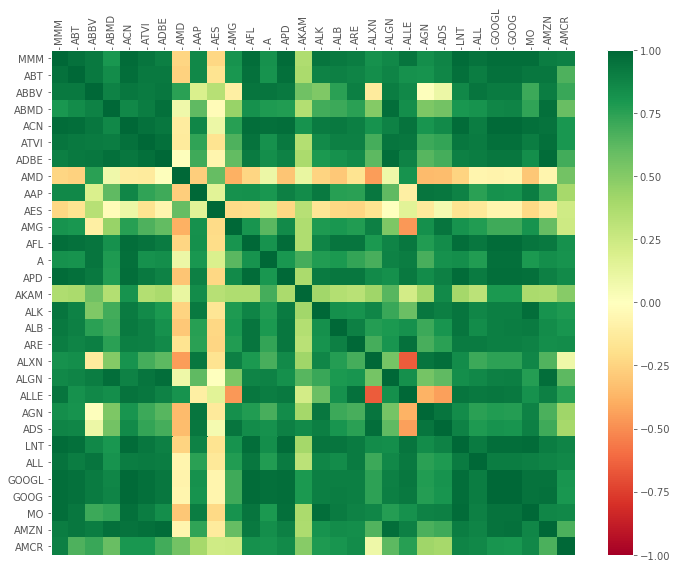

In [31]:
%matplotlib inline
def visualize_data():
    df = pd.read_csv('sp_500_30_joined_closes.csv')
    #df[ticker].plot()
    df_corr = df.corr()
    data = df_corr.values # returns a numpy array of the data we saw
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1,1,1) #1 by 1 plot, plotting the first plot
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    #'Rd' means read; 'Yl' means 'yl'; 'Gn' means 'green'
    # this is a heat map with range going from red as negative to yellow as neutral to green as positive.
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    # the 0.5 plus, takes the ticks to being placed in between the numbers,
    # at the 0.5 position, 1.5 position and so on.
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    # the next two operations are done so that the heat map appear as
    # like a table as possible.
    ax.invert_yaxis() #invert the y-axis to start from the max value (at below) and ends at 0
    ax.xaxis.tick_top() # moves x-ticks to the top
    
    # both information below are identical 
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90) # rotating x-ticks labels 90 degrees
    heatmap.set_clim(-1, 1) # limits the heatmap colors to this range of values;
    # if not set, the color range obeys the limit found in data.
    plt.tight_layout()
    plt.show()
    
visualize_data()

#### Preprocessing data for ML
We've saw that there're relationships between different enterprise's information. The questions is: can we build a machine to recognize these relationships?

Let's decrease our problem a bit and consider that groups of companies are likely to move together, either up or down. But that's not always the case, some companies can move before others, that may suffer some kind of a lag. Given this, can we take the movement of other companies as well as the current company in question (instead of looking solely at the history prices of this single company), using only stock prices info, to give us a real hedge?

*Hedging is the practice of purchasing and holding securities to reduce portfolio risk. These securities are intended to move in a different direction than the rest of the portfolio. They tend to appreciate when other investments decline. A put option on a stock or index is the classic hedging instrument.*

To do that we'll:
1. convert pricing data to percentage changes (to normalize data); that we'll be our features for the learning machine;
2. the labels of the system we'll be 'Buy', 'Sell' or 'Hold'; that will be a multi-class classification machine.
3. we'll be asking the learned system: will the price, within the next seven trading days, go up more than 2%? If yes, that will be a 'buy'; if the system believes that it will fall more than 2%, that will be a 'sell'; if it did neither of those cases, that will be a 'hold'.

Look that we've chosen 7 days as default. Other values may be tested and we can pick the optimal window in terms of machine's performance. However, if the window is too large, 30 days for example, we may miss any correlation.

Also, you don't wanna look back more than 2 or even 1 year of correlations data for training, because companies correlations may change significantly over time. Because we lose to much data here, we may need to rely on other sources of data or data with more granularity.

We're going to generate a machine for each company, but each machine will take into account the prices of all other companies in the S&P 500 (or in the range we've defined).

In [32]:
def process_data_for_labels(ticker, hm_days=7, number_enterprises=30):
    # how many days in the future we'll be looking at.
    df = pd.read_csv('sp_500_{}_joined_closes.csv'.format(str(number_enterprises)), index_col=0)
    tickers = df.columns.values.tolist() # get the list of enterprises
    df.fillna(0, inplace=True)
    
    for i in range(1, hm_days+1):
        # evalauting the percentage changes and creating columns for each of the days.
        # to get future data i periods, we shift-up the data i times.
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i)
                - df[ticker]) / df[ticker]
    #Look at those prints below to get insight of what's going on:
    #print(df['GOOG'].tail())
    #print(df['GOOG_1d'].head())
    df.fillna(0, inplace=True) # for the last 7th days those df['{}_{}d'] columns will have NaN values.
    #print(df['GOOG_1d'].head())
    #print(df['GOOG_1d'].tail())
    #print(df['GOOG_7d'].tail()) # that's the percentage change of the 7th day compared with the 0th day.
    return tickers, df
    
process_data_for_labels('GOOG')

(['MMM',
  'ABT',
  'ABBV',
  'ABMD',
  'ACN',
  'ATVI',
  'ADBE',
  'AMD',
  'AAP',
  'AES',
  'AMG',
  'AFL',
  'A',
  'APD',
  'AKAM',
  'ALK',
  'ALB',
  'ARE',
  'ALXN',
  'ALGN',
  'ALLE',
  'AGN',
  'ADS',
  'LNT',
  'ALL',
  'GOOGL',
  'GOOG',
  'MO',
  'AMZN',
  'AMCR'],
                    MMM        ABT       ABBV        ABMD         ACN  \
 Date                                                                   
 2000-01-03   29.101397   9.714566   0.000000   18.250000    0.000000   
 2000-01-04   27.945047   9.437006   0.000000   17.812500    0.000000   
 2000-01-05   28.754490   9.419660   0.000000   18.000000    0.000000   
 2000-01-06   31.067183   9.749260   0.000000   18.031250    0.000000   
 2000-01-07   31.683905   9.853342   0.000000   17.937500    0.000000   
 2000-01-10   31.529728   9.783957   0.000000   20.500000    0.000000   
 2000-01-11   30.990091   9.645175   0.000000   19.812500    0.000000   
 2000-01-12   31.067183   9.500832   0.000000   19.593750    0

Now, we'll write a function that we'll use to map our pandas data frame to build the target 'buy', 'sell' or 'hold' function.

The idea here is to get a slighly hedge, i.e., to get a performance slighly better than 33%.

In [33]:
# that's going to be our mapping function:
def buy_sell_hold(*args, requirement=0.02): #it allows us to pass any number of arguments,
    #in this iterable object called 'args'.
    # Here, the args will be the seven day percent changes for the prices in the feature, i.e.,
    # the following columns: df['{}_{}d'.format(ticker, i)]
    cols = [c for c in args]
    for col in cols:
        if col > requirement: # step 1
            return 1
        if col < -requirement: # step 2
            return -1
    return 0 # step 2

In *step 1* we're saying: at any point at any of these columns (at any day within the next seven days), if the value of that column is greater than the requirement, we are returning 1 (buy). For example, if the df['GOOG_1d'] percentage change value is higher than 0.02 we'll put it as a buy. Previous days have higher priority.

In *step 2* we're saying: if that column is less than the negative requirement, than we are returning -1 (sell).

In *step 3* we're saying: otherwise, if we get through all the columns (all the next seven days) and we haven't returned something yet, we'll return 0 (hold).

What we want here is that as soon as we got the trigger for buying or selling we buy or sell. In the case of buying, to be conservative, we may put position to sell that stock at 1.5% of the price we've paid. Also, we may have a stop loss at negative 1.5-2.0%.

Note: pay attention to not include future columns as your features, because your classifier will be very good at predicting future prices, however it's doing that using unfeasible information.

In [55]:
def extract_featuresets(ticker, hm_days=7):
    tickers, df = process_data_for_labels(ticker, hm_days=hm_days)
    # creating a new column for the target; we're passing to the
    # mapping function to all next 7 day percent changes.
    df['{}_target'.format(ticker)] = list(map(buy_sell_hold, *[df['{}_{}d'.format(ticker, i)]for i in range(1, hm_days+1)]))
    print(df['{}_target'.format(ticker)].tail())
    # We still have prices of all other companies in our df.
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread: ', Counter(str_vals)) # count different values in a list of Strings
    
    # df is the data frame of raw prices.
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    # getting the feature values for all the enterprises using the pct_change Pandas
    # function that evaluates the percentage change between the current and a prior element.
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values # numpy matrix of the data frame
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df
    
extract_featuresets('GOOG')

Date
2018-12-24    1
2018-12-26    0
2018-12-27    0
2018-12-28    0
2018-12-31    0
Name: GOOG_target, dtype: int64
Data spread:  Counter({'0': 1771, '1': 1688, '-1': 1320})


(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.03973518, -0.02857155,  0.        , ...,  0.00800032,
         -0.08321678,  0.        ],
        [ 0.02896551, -0.00183812,  0.        , ..., -0.00529117,
         -0.14874142,  0.        ],
        ...,
        [ 0.02383763,  0.01450722,  0.00977092, ...,  0.00557521,
         -0.00629547,  0.        ],
        [-0.00697424,  0.00651265,  0.01345795, ...,  0.00390131,
          0.01120659,  0.06285712],
        [ 0.00617838,  0.01744294,  0.01174272, ...,  0.010227  ,
          0.01620408,  0.        ]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
                    MMM        ABT       ABBV        ABMD         ACN  \
 Date                                                                   
 2000-01-03   29.101397   9.714566   0.000000   18.250000    0.000000   
 2000-01-04   27.945047   9.437006   0.000000   17.812500    0.000000   
 2000-01-05   28.754490   9.419660 

Note that we have three classes, however system that choses randomly a label would not give us 33% accuracy, because stocks, on average, don't go sideways, they go up in price. To make a fair distribution between buy, sell and hold, we may want to tune the 0.02 requirement. Look at the number above, indeed, the number of 'buys' is 34% higher than the number os 'sells' for the GOOG symbol in the given period.

#### Creating the learning machine

Let's train our classifiers. Remember that if we're happy to their performances, all we have to do is to pickle out the trained classifier and use the method predict() to new daily data.

In [62]:
def do_ml(ticker, model):
    X, y, _ = extract_featuresets(ticker)
    print(y[0])
    # split arrays or matrices into random train and test subsets
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    # modeling
    if model == 1: # knn neighbors
        clf = neighbors.KNeighborsClassifier()
    elif model == 2: # ensemble of three classifiers
        clf = VotingClassifier([('linearSVC', svm.LinearSVC()),
                                ('knn', neighbors.KNeighborsClassifier()),
                                ('randomForest', RandomForestClassifier())])
    
    
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print('Accuracy: ', confidence)
    predictions = clf.predict(X_test)\
    # Chacking if the classifier is predicting only one label (common phenomena in imbalanced data)
    print('Predicted spread:', Counter(predictions))
    
    return confidence

do_ml('GOOGL', model=1)

Date
2018-12-24    1
2018-12-26    0
2018-12-27    0
2018-12-28    0
2018-12-31    0
Name: GOOGL_target, dtype: int64
Data spread:  Counter({'0': 1743, '1': 1700, '-1': 1336})
0
Accuracy:  0.4165968147527242
Predicted spread: Counter({1: 435, -1: 404, 0: 354})


0.4165968147527242

In [63]:
do_ml('GOOGL', model=2)

Date
2018-12-24    1
2018-12-26    0
2018-12-27    0
2018-12-28    0
2018-12-31    0
Name: GOOGL_target, dtype: int64
Data spread:  Counter({'0': 1743, '1': 1700, '-1': 1336})
0
Accuracy:  0.4979044425817267
Predicted spread: Counter({0: 456, -1: 411, 1: 326})


0.4979044425817267

Of course, there's a lot room for improvement here:
- changing the default parameter values;
- dealing with imbalanced nature of the problem properly;
- looking at the errors and try to develop strategies for them (for example, a 1.5% increase for this strategy is a hold, but it's still a very good buy).
- changing the requirement for other values to get a more balanced data (we may even consider different requirements for buy and sell).
